In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from scipy import stats
from dataset import dataset

In [2]:
def q_stat(r):
    q = []
    for i in range(r.shape[0]):
        q.append(np.matmul(r[i], r[i].T))
    return np.array(q)

In [3]:
num_features = 6
data = dataset(num_features=num_features)
print(data.keys())
print(data['a1'].keys())

dict_keys(['healthy', 'a1', 'a6', 'a17', 'a18'])
dict_keys([10, 20, 30, 40, 50, 60, 70, 80, 90])


In [4]:
healthy = data['healthy']
scaler = MinMaxScaler()
healthy_norm = scaler.fit_transform(healthy)
healthy_train, healthy_test = train_test_split(healthy_norm, test_size=20, train_size=80)
healthy_train, healthy_valid = train_test_split(healthy_train, test_size=20, train_size=60)

In [5]:
print(healthy_train.shape, healthy_valid.shape, healthy_test.shape)

(60, 6) (20, 6) (20, 6)


In [6]:
defective_valid, defective_test = [], []
beams = ['a6', 'a17', 'a18']
damages = range(10, 91, 10)
for beam in beams:
    for damage in damages:
        defective = data[beam][damage]
        defective_norm = scaler.transform(defective)
        valid, test = train_test_split(defective_norm, test_size=50, train_size=50)
        defective_valid.append(valid)
        defective_test.append(test)
defective_valid = np.concatenate(defective_valid, axis=0)
defective_test = np.concatenate(defective_test, axis=0)

## ROC Curve

In [7]:
fprs, fnrs = [], []
for n_pc in range(1, num_features):
    pca = PCA(n_components=n_pc, svd_solver='full')
    pca.fit(healthy_train)
    
    healthy_valid_recons = pca.inverse_transform(pca.transform(healthy_valid))
    healthy_valid_residual = healthy_valid_recons - healthy_valid
    healthy_valid_q = q_stat(healthy_valid_residual)
    
    defective_valid_recons = pca.inverse_transform(pca.transform(defective_valid))
    defective_valid_residual = defective_valid_recons - defective_valid
    defective_valid_q = q_stat(defective_valid_residual)
    
    fpr, fnr = [], []
    conf_range = range(800, 1000)
    for conf in conf_range:
        # Q-statistic threshold
        c_alpha = stats.norm.ppf(conf / 1000)
        cov = np.cov(healthy_train.T)
        d, _ = np.linalg.eig(cov)
        d = np.sort(d)[::-1]
        theta = []
        for i in range(3):
            theta.append(np.sum(np.array(d[n_pc:]) ** (i + 1)))
        h_0 = 1 - (2 * theta[0] * theta[2]) / (3 * theta[1] ** 2)
        q_alpha = theta[0] * np.power((c_alpha * h_0 * np.sqrt(
            2 * theta[1]) / theta[0] + 1 + theta[1] * h_0 * (h_0 - 1) / theta[0] ** 2), 1 / h_0)
        
        healthy_valid_y = np.zeros(healthy_valid_q.shape)  # 0 = Healthy (negative), 1 = Failed (positive)
        defective_valid_y = np.zeros(defective_valid_q.shape)
        
        for i in range(healthy_valid_q.shape[0]):
            if not healthy_valid_q[i] <= q_alpha:
                healthy_valid_y[i] = 1
        for i in range(defective_valid_q.shape[0]):
            if not defective_valid_q[i] <= q_alpha:
                defective_valid_y[i] = 1
        
        fpr.append(np.count_nonzero(healthy_valid_y) / healthy_valid_y.shape[0])
        fnr.append(1 - np.count_nonzero(defective_valid_y) / defective_valid_y.shape[0])
    
    fprs.append(fpr)
    fnrs.append(fnr)

In [8]:
all_fprs = [item for sublist in fprs for item in sublist]
all_fnrs = [item for sublist in fnrs for item in sublist]

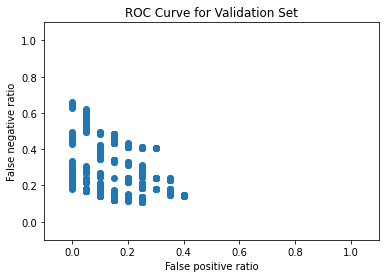

In [9]:
plt.figure()
plt.scatter(all_fprs, all_fnrs)
plt.xlabel('False positive ratio')
plt.ylabel('False negative ratio')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('ROC Curve for Validation Set')
plt.show()

In [15]:
# distances = []
# for i in range(len(all_fprs)):
#     distances.append(np.sqrt(all_fprs[i] ** 2 + all_fnrs[i] ** 2))
# min_idx = np.argmin(distances)
# print(min_idx)

allowed_fpr = 0
min_fnr = 1
min_idx = 0
for i in range(len(all_fnrs)):
    if all_fprs[i] == allowed_fpr:
        if all_fnrs[i] < min_fnr:
            min_fnr = all_fnrs[i]
            min_idx = i
print(min_idx, min_fnr)

147 0.18148148148148147


In [16]:
best_fpr = all_fprs[min_idx]
best_fnr = all_fnrs[min_idx]
print(best_fpr, best_fnr)

0.0 0.18148148148148147


In [17]:
best_n_pc = int(np.ceil(min_idx / len(fprs[0])))
print(best_n_pc)

1


In [18]:
conf_idx = min_idx
while conf_idx >= 200:
    conf_idx -= 200
best_conf = conf_range[conf_idx] / 1000
print(best_conf)

0.947


## Testing

In [19]:
pca = PCA(n_components=best_n_pc, svd_solver='full')
pca.fit(healthy_train)

healthy_test_recons = pca.inverse_transform(pca.transform(healthy_test))
healthy_test_residual = healthy_test_recons - healthy_test
healthy_test_q = q_stat(healthy_test_residual)

defective_test_recons = pca.inverse_transform(pca.transform(defective_test))
defective_test_residual = defective_test_recons - defective_test
defective_test_q = q_stat(defective_test_residual)

# Q-statistic threshold
c_alpha = stats.norm.ppf(best_conf)
cov = np.cov(healthy_train.T)
d, _ = np.linalg.eig(cov)
d = np.sort(d)[::-1]
theta = []
for i in range(3):
    theta.append(np.sum(np.array(d[best_n_pc:]) ** (i + 1)))
h_0 = 1 - (2 * theta[0] * theta[2]) / (3 * theta[1] ** 2)
q_alpha = theta[0] * np.power((c_alpha * h_0 * np.sqrt(
    2 * theta[1]) / theta[0] + 1 + theta[1] * h_0 * (h_0 - 1) / theta[0] ** 2), 1 / h_0)

healthy_test_y = np.zeros(healthy_test_q.shape)  # 0 = Healthy (negative), 1 = Failed (positive)
defective_test_y = np.zeros(defective_test_q.shape)

for i in range(healthy_test_q.shape[0]):
    if not healthy_test_q[i] <= q_alpha:
        healthy_test_y[i] = 1
for i in range(defective_test_q.shape[0]):
    if not defective_test_q[i] <= q_alpha:
        defective_test_y[i] = 1

fpr_test = np.count_nonzero(healthy_test_y) / healthy_test_y.shape[0]
fnr_test = 1 - np.count_nonzero(defective_test_y) / defective_test_y.shape[0]

print(fpr_test, fnr_test)

0.05 0.18518518518518523


## FNR vs. Cross-Section Reduction

In [55]:
dic = {}
for key in damages:
    dic[key] = []

n_per_beam = int(defective_test_q.shape[0] / len(beams))
n_per_damage = int(n_per_beam / len(damages))

for i in range(len(beams)):
    q = defective_test_q[i * n_per_beam:(i + 1) * n_per_beam]
    for i, damage in enumerate(damages):
        q_damage = q[i * n_per_damage:(i + 1) * n_per_damage]
        dic[damage].append(q_damage)

for key in dic.keys():
    dic[key] = np.concatenate(dic[key], axis=0)

In [59]:
fnr = []
for damage in dic.keys():
    q = dic[damage]
    y = np.zeros(q.shape)
    for i in range(q.shape[0]):
        if not q[i] <= q_alpha:
            y[i] = 1
    fnr.append(1 - np.count_nonzero(y) / y.shape[0])

In [70]:
print(fnr)

[0.8133333333333334, 0.6333333333333333, 0.21333333333333337, 0.00666666666666671, 0.0, 0.0, 0.0, 0.0, 0.0]


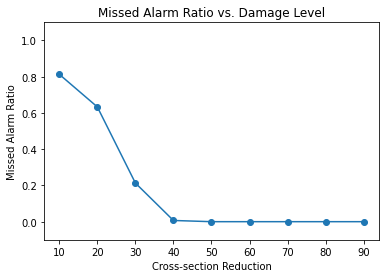

In [69]:
plt.figure()
plt.plot(range(10, 91, 10), fnr)
plt.scatter(range(10, 91, 10), fnr)
plt.xlabel('Cross-section Reduction')
plt.ylabel('Missed Alarm Ratio')
plt.title('Missed Alarm Ratio vs. Damage Level')
plt.ylim([-0.1, 1.1])
plt.show()